In [2]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np

import os
import re

from prep_data import preprocess_data_3

train_data, test_data = preprocess_data_3(17, 1, 16, 0.9)

Make sure the loss function and the activation function are not leading to vanishing gradients

In [3]:
import torch
from torch import nn
import numpy as np

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

device = cuda_get_device()

class GRUModel(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, n_layers):
		super(GRUModel, self).__init__()

		# Defining some parameters
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers

		#Defining the layers
		self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_dim)
		# May need a separate fc layer for each GRU unit?
		self.fc = nn.Linear(hidden_dim, output_size)
	
	def forward(self, x):
		# Passing in the input into the GRU layer
		hidden = self.gru(x)[0]
		
		# Reshaping the outputs such that it can be fit into the fully connected layer
		hidden = hidden.contiguous().view(-1, self.hidden_dim)
		out = self.fc(hidden)
		
		return out

# Model Hyperparameters
hidden_state_size = 12
fc_layers = 1
# Training hyperparameters
n_epochs = 1000#200
lr=0.005

# Instantiate the model with hyperparameters
model = GRUModel(input_size=64, output_size=1, hidden_dim=hidden_state_size, n_layers=fc_layers)
model.to(device)

# Define Loss, Optimizer
# We may want to increase gamma so that the number of epochs can be reduced
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
milestones = [150, 300]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Training Run
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	for data in train_data:
		optimizer.zero_grad()
		input_data = torch.from_numpy(data[0]).float().to(device)
		target_pred = torch.tensor(data[1]).unsqueeze(0).float().to(device)
		output = model(input_data)[-1]
		# print(torch.log(torch.sigmoid(output)).item(), torch.log(1 - torch.sigmoid(output)).item(), target_pred.item())
		loss = criterion(output, target_pred)
		# print(loss)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(epoch_losses.to('cpu').item()))

c:\Users\jcarl\anaconda3\envs\Pytorch_3_9\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 5/1000............. Loss: 116.9837
Epoch: 10/1000............. Loss: 135.3422
Epoch: 15/1000............. Loss: 109.5095
Epoch: 20/1000............. Loss: 107.7062
Epoch: 25/1000............. Loss: 95.6160
Epoch: 30/1000............. Loss: 95.9653
Epoch: 35/1000............. Loss: 71.0187
Epoch: 40/1000............. Loss: 133.4963
Epoch: 45/1000............. Loss: 205.1908
Epoch: 50/1000............. Loss: 104.5193
Epoch: 55/1000............. Loss: 88.4497
Epoch: 60/1000............. Loss: 110.1077
Epoch: 65/1000............. Loss: 82.6178
Epoch: 70/1000............. Loss: 132.5749
Epoch: 75/1000............. Loss: 123.8455
Epoch: 80/1000............. Loss: 30.4718
Epoch: 85/1000............. Loss: 132.8244
Epoch: 90/1000............. Loss: 109.3778
Epoch: 95/1000............. Loss: 104.5422
Epoch: 100/1000............. Loss: 107.2118
Epoch: 105/1000............. Loss: 91.1917
Epoch: 110/1000............. Loss: 137.9577
Epoch: 115/1000............. Loss: 120.0992
Epoch: 120/1000

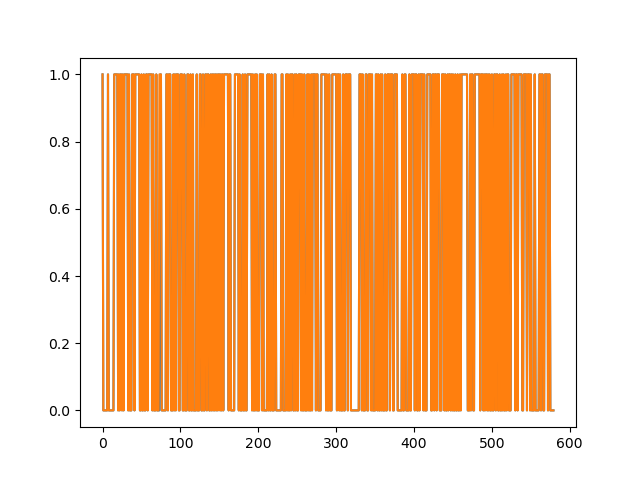

1
290
289


In [7]:
import matplotlib.pyplot as plt

predictions = []
targets = []
with torch.no_grad():
	for data in train_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

# plt.figure()
# plt.plot(pred)
# plt.plot(targets_numpy)
# plt.show()

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(targets_numpy))
print(np.sum(pred))

In [8]:
# Evaluate on the test dataset

predictions = []
targets = []
with torch.no_grad():
	for data in test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(pred))
print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(targets_numpy))

# print(np.where(test_targets != pred))
# print(np.where(np.abs(test_targets-pred) != 0))

30
13
33


In [9]:
print(len(test_data))

66
